In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from transformers import DistilBertModel
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
import cv2


c:\Users\djankows\Documents\Artificial Intelligence\SEM 5\cv-project3\reverse-image-search\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reverse Search Engine Project #

Daniel Jankowski 148257

## The goal of the project ##

Reverse image search engines using neural networks are a type of image search technology that allow users to search for similar images to a given query image. The problem is to develop a system that can accurately and efficiently find similar images in a large dataset, by using neural networks to extract and compare features of the images. This can be challenging due to the large amount of data and variations in image content and quality.

The goal of the project is to prepare system which finds similar images based on the query image using neural networks. Additional implemented features are searching images based on the text input or describing uploaded images to the system. The final version of the application should run in docker containers as microservice with UI available via web application.

## Selected dataset ##

**The Flickr8k** dataset is a collection of 8,000 images and associated captions, which is commonly used for training and evaluating image captioning models. The images in the dataset were collected from the Flickr website and cover a wide range of subjects. The captions were generated by crowdsourcing, with each image having at least five captions. The dataset is widely used in the field of computer vision for the development of image captioning models.

The Flickr8k dataset is a good dataset for reverse image search engines because it contains a large number of images and captions that are diverse and representative of real-world images. The captions provide a textual description of the content of each image, which can be used to train models that can understand and describe the images. This allows us to train the model for not only finding similar images, but also for finding apprioriate images based on the text query.

In [2]:
captions = pd.read_csv("..\data\captions.csv")
captions['id'] = [_id for _id in range(captions.shape[0] // 5) for _ in range(5)]

In [3]:
def plot_random(images, captions, inx):
    img = cv2.imread("..\data\Images\\"+images[inx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    for _ in range(inx, inx+5):
        print(captions[_])

A black dog and a brown dog are jumping up to catch a red toy .
A black dog and a brown dog play with a red toy on a courtyard .
A brown and black lab are outside and the black lab is catching a toy in its mouth .
Black dog snaps at red and black object as brown dog lunges .
The Chocolate Lab jumps too late to get the toy as the Black Lab captures it in the driveway .


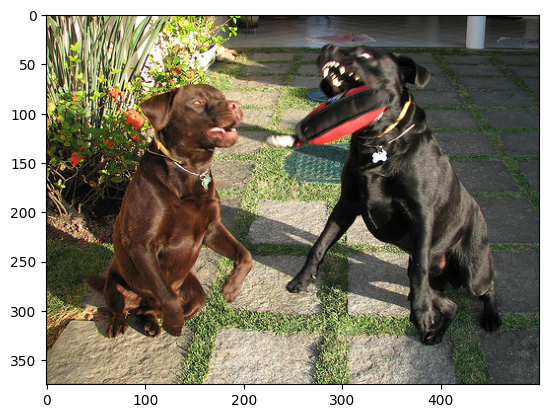

In [4]:
plot_random(captions['image'].values, captions['caption'].values, 120)

A boy with a blue hat points towards a bowl full of cork .
A child in medieval clothes points at something on a table .
A child in period costume looking at a table with a bowl , cup , and a basket of apples .
A young boy next to apples at a medieval fair .
The child is sitting at the table with art supplies and apples .


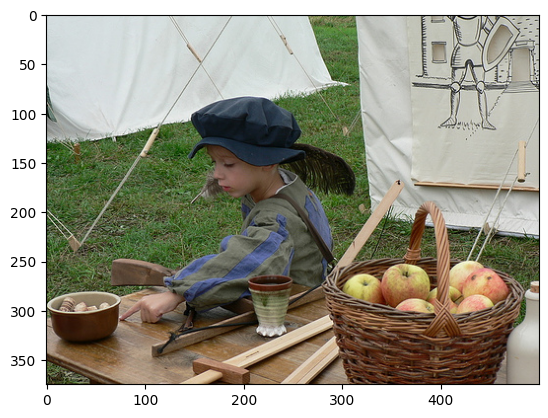

In [5]:
plot_random(captions['image'].values, captions['caption'].values, 4210)

A football player clutches the ball while running down the field .
A football player running with the ball .
A football player running with the ball at a game .
A football player wearing a gold helmet runs holding a football .
an American footballer in a white strip is making a run with the ball .


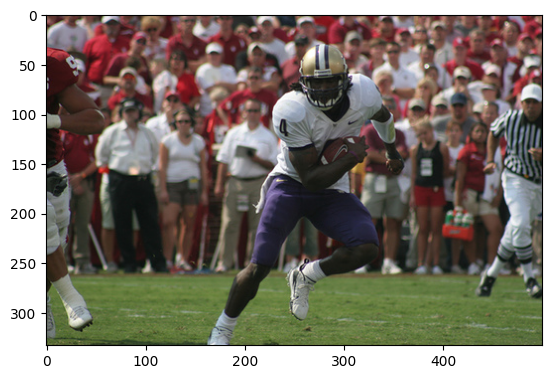

In [6]:
plot_random(captions['image'].values, captions['caption'].values, 8920)

A man blows into an electrical instrument by a microphone .
A man blows into a tube while standing in front of a man at the drumset onstage .
A man plays an instrument next to a drummer .
a musician plays a strange pipe instrument whilst standing next to a drummer on a stage .
Two men perform a song together onstage .


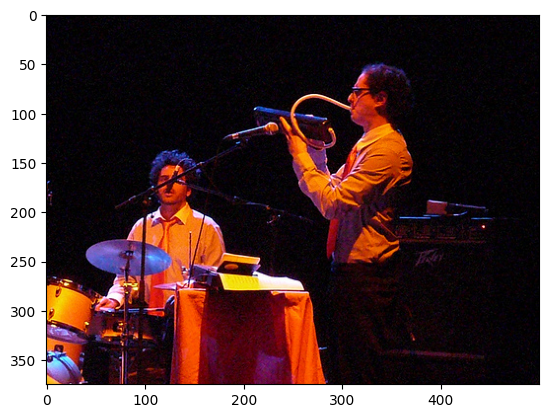

In [7]:
plot_random(captions['image'].values, captions['caption'].values, 20420)

## Software and models architectures ##

### System architecture ###

![architecture](resources/architecture.png)

The heart of the system is the Search Engine component, which is controlled by the Rest API. The Search Engine is responsible for processing inputs into embeddings using the CLIP Based Model, and then searching for similar content based on them.

### CLIP Model ###

**Main reference** <br>
https://arxiv.org/pdf/2103.00020.pdf

CLIP (Contrastive Language-Image Pre-training) is a neural network model developed by OpenAI that is designed to improve the performance of image recognition and language understanding tasks. The model is based on the idea of pre-training a neural network on a large dataset of images and their associated captions, and then fine-tuning the network on specific tasks such as image classification or image captioning.

The key idea behind CLIP is that it uses a contrastive learning approach where the model is trained to distinguish between true and false captions for a given image. This allows the model to learn to understand the relationship between language and image, and to generalize this understanding to new images and captions.

CLIP uses a transformer-based architecture which is commonly used in natural language processing tasks and it's fine-tuned using supervised learning on specific tasks. Additionally, CLIP is trained using a massive amount of data and it's capable of generalizing well to novel images and captions.

Overall, CLIP is considered as a powerful model that has shown to improve the performance of image recognition and language understanding tasks in multiple benchmarks.

![clip-approach](resources/clip_approach.PNG)

***Core of CLIP model in pseudocode***

```python
# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
# T[n, l] - minibatch of aligned texts
# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter
# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]
# joint multimodal embedding [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)
# symmetric loss function
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```



#### CLIP Model in PyTorch ####

**Image Encoder**

In [8]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name: str = "resnet50"):
        """Image encoder used for extracting image features

        Args:
            model_name (str, optional): Version of resnet architecture. Defaults to "resnet50".

        Raises:
            ValueError: Raise when incorrect resnet model has been choosen.
        """
        super(ImageEncoder, self).__init__()
        if model_name == "resnet18":
            resnet = models.resnet18(pretrained=True)
        elif model_name == "resnet50":
            resnet = models.resnet50(pretrained=True)
        else:
            raise ValueError("Incorrect type of ResNet architecture.")
        
        self.model = torch.nn.Sequential(*(list(resnet.children())[:-1]))

        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, images: torch.tensor) -> torch.tensor:
        return self.model(images).squeeze()

As an image encoder I used pretrained ResNet50 model architecture. 

ResNet50 is a convolutional neural network architecture that can be used to extract image embeddings. Image embeddings are a compact representation of an image that capture the most important features of the image. ResNet50 is trained on a large dataset of images, allowing it to learn a rich set of features that can be used to represent images.


The implementation is done this way to allow also using smaller version - ResNet18, however, the final version of search engine uses ResNet50 due to the performance.

![resnet50](resources/resnet50.png)

ResNet50 is a convolutional neural network architecture that can be used to extract image embeddings. Image embeddings are a compact representation of an image that capture the most important features of the image. The architecture is trained on a large dataset of images, allowing it to learn a rich set of features that can be used to represent images.

To extract image embeddings using ResNet50, the last layer of the model (classifier) has been removed. Thanks to that, as an output we obtain a vector of size 2048, which describe an image and its most important features. 

**Text Encoder**

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, model_name: str = 'distilbert-base-uncased'):
        """Text encoder based on pretrained BERT model

        Args:
            model_name (str, optional): Name of the bert model. Defaults to 'distilbert-base-uncased'.
        """
        super(TextEncoder, self).__init__()
        self.model = DistilBertModel.from_pretrained(model_name)
            
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]
        embedding = hidden_state[:, 0]
        return embedding

In case of extracting embeddings for image captions and other text inputs I have used pre-trained DistilBERT model.

DistilBERT is a distilled version of BERT, a transformer-based language model developed by Google. The main idea behind distillation is to transfer the knowledge learned by a larger, more complex model (the teacher) to a smaller, more computationally efficient model (the student).

DistilBERT architecture is composed of a multi-layer transformer encoder, which is the main component of transformer-based language models. The architecture is composed of several layers of self-attention and feed-forward layers. The self-attention layers allow the model to attend to different parts of the input sentence, while the feed-forward layers allow the model to learn non-linear representations of the input. DistilBERT uses a technique called distillation to transfer the knowledge learned by the larger BERT model to a smaller architecture, which is more computationally efficient.

In contrast to image embeddings, the transformed texts are represented by vector of size 768, which is the default embeddings size from BERT models.

**Dual Encoder**

In [10]:
class ProjectionHead(nn.Module):
    def __init__(
        self, embedding_dim: int, project_dim: int = 256, dropout: float = 0.2
    ) -> None:
        """Projection model which map image and texts embeddings to the same dimension.
        It allows us to compare images and texts

        Args:
            embedding_dim (int): Input embedding size
            project_dim (int, optional): Output dimension. Defaults to 256.
            dropout (float, optional): Dropout value - factor of how many neurons are dropped out. Defaults to 0.2.
        """
        super(ProjectionHead, self).__init__()
        self.l1 = nn.Linear(embedding_dim, project_dim)
        self.gelu = nn.GELU()
        self.l2 = nn.Linear(project_dim, project_dim)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(project_dim)

    def forward(self, embedding):
        output = self.l1(embedding)
        embedding = self.gelu(output)
        embedding = self.l2(embedding)
        embedding = self.dropout(embedding)
        embedding = embedding + output
        embedding = self.norm(embedding)
        return embedding

**Dual Encoder**

In [11]:
class DualEncoder(nn.Module):
    def __init__(
        self,
        resnet: str = "resnet50",
        img_embedding_dim: int = 2048,
        text_embedding_dim: int = 768,
        temperature: float = 1.0,
    ):
        super(DualEncoder, self).__init__()
        self.image_encoder = ImageEncoder(resnet)
        self.text_encoder = TextEncoder()
        self.image_mapper = ProjectionHead(img_embedding_dim)
        self.text_mapper = ProjectionHead(text_embedding_dim)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_mapper(image_features)
        text_embeddings = self.text_mapper(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = nn.functional.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = nn.CrossEntropyLoss(logits, targets, reduction="none")
        images_loss = nn.CrossEntropyLoss(logits.T, targets.T, reduction="none")
        loss = (images_loss + texts_loss) / 2.0
        return loss.mean()

In [12]:
model = DualEncoder()

c:\Users\djankows\Documents\Artificial Intelligence\SEM 5\cv-project3\reverse-image-search\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\djankows\Documents\Artificial Intelligence\SEM 5\cv-project3\reverse-image-search\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_no

In [13]:
model

DualEncoder(
  (image_encoder): ImageEncoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=Tru

## Training & Evaluation ##

For this part prepared is separated jupyter notebook, which was executed in google colab environment, however, outputs from cells are keeped to show the results.

### Train, valid, test split ###

The dataset has been splitted into three parts with ratio 70:15:15 in as balanced way at it was possible. Our dataset contains ~8000 images and each image is decribe by five captions. During splitting, I used stratify attribute in `train_test_split` from sklearn package to ensure that each image is in (almost*) every set of data. 

After splitting:
- Training data: 28318 records
- Validation data: 6068 records
- Test data: 6069 records


(*almost, because some of the images are not present in test set, because sklearn was not able to stratify that less number of one class objects)

### Training parameters ###

For training there was used Adam optimizer, the same was used by OpenAI based on their paper. 

### Training ###

First step to validate whether everything is okay with training loop and model itself was to run traning just for 2 epochs. Time needed for one epoch was ~11 minutes. This experiment didn't throw any errors, moreover, the model after just two epochs had quite good performance. 

Finally, the model has been trained for 6 epochs with batch size equal to 32. Due to the constraints of the free version of Google Colab, it was quite impossible to train model for the higher number of epochs. the total training took ~1 hour. 

![loss](resources/loss.png)

### Evaluation ###

Evaluating search engine was quite challenging for me, however I decided to evaluate the model as follows:


Our testset contains 6069 recored, i.e. 6069 different queries and X different images. Each query has only one relevent image along the whole testset. During the evaluation a "point" was given, when the relevant image for a given query was in the **first 10 results**. At the end, number of points was divided by the length of the testset. In my opinion, the evaluation of the search engine is not *binary problem*, therefore I compare the results applying described rule considering different K value (first K results was considered). The results were as follows:

| @K   | % of relevant image found |
|------|---------------------------|
| @10  | 49%                       |
| @20  | 63.7%                     |
| @50  | 81.2%                     |
| @100 | 90.6%                     |



I also considered computing `Recall@K` and `Precision@K`, however in our case, for particular testset, it doesn't make much sense, since number of relevant image is always 1.



## References ##

Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k <br>

Other resources: 

https://arxiv.org/pdf/2103.00020.pdf <br>
https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 <br>
https://keras.io/examples/nlp/nl_image_search/ <br>
https://github.com/moein-shariatnia/OpenAI-CLIP <br>